In [1]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
from clean_tweets_dataframe import CleanTweets
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
import warnings
from pprint import pprint
import string
import pyLDAvis.gensim as gensimvis
import pickle 
import pyLDAvis
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df_tweet=pd.read_csv("processed_tweet_data.csv")

In [4]:
cleaner=CleanTweets(df_tweet)

Automation in Action...!!!


**Using cleaner module from clean_tweets_dataframe to clean the imported dataset**

In [5]:
df_tweet=cleaner.drop_unwanted_column(df_tweet)
df_tweet=cleaner.drop_duplicate(df_tweet)
df_tweet=cleaner.convert_to_datetime(df_tweet)
df_tweet=cleaner.convert_to_numbers(df_tweet)
# df_tweet=cleaner.remove_non_english_tweets(df_tweet)

In [6]:
# df_tweet.head()

In [7]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24514 entries, 0 to 24624
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   created_at              24514 non-null  datetime64[ns, UTC]
 1   source                  24514 non-null  object             
 2   original_text           24514 non-null  object             
 3   cleaned_text            23949 non-null  object             
 4   polarity                24514 non-null  float64            
 5   subjectivity            24514 non-null  float64            
 6   sentiment               24514 non-null  object             
 7   lang                    24514 non-null  object             
 8   favorite_count          24514 non-null  int64              
 9   retweet_count           24514 non-null  int64              
 10  original_author         24514 non-null  object             
 11  followers_count         24514 non-null  i

### EDA of Tweets

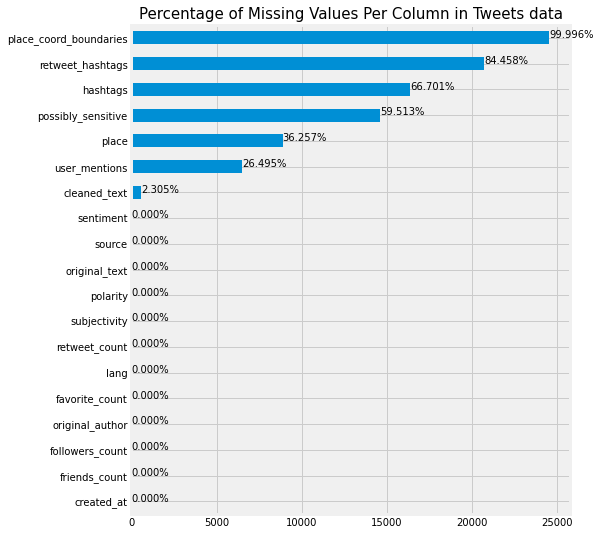

In [8]:
# Check the percentage of missing values in every column
ax = df_tweet.isna().sum().sort_values().plot(kind = 'barh', figsize = (7, 9))
plt.title('Percentage of Missing Values Per Column in Tweets data', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.3f}%'.format((p.get_width()/df_tweet.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

<AxesSubplot:ylabel='Actual Hashtags'>

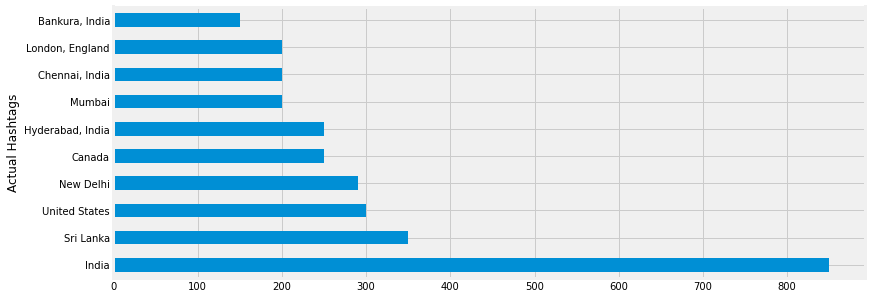

In [9]:
# df_tweet.groupby('place').count()['original_author']
df_tweet['place'].value_counts(sort=True, ascending=False)[:10].plot(kind='barh',figsize=(12,5),xlabel='Actual Hashtags')

In [10]:
df_tweet_date=df_tweet.set_index('created_at')

<AxesSubplot:xlabel='created_at'>

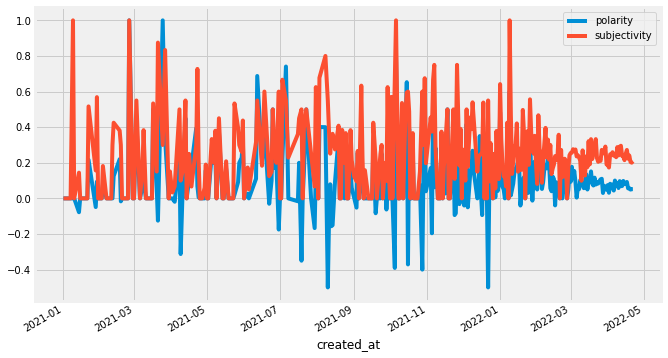

In [11]:
df_tweet_date.resample('D').mean()[['polarity','subjectivity']].dropna().plot(figsize=(10,6))

### uni-variate Analysis on Hashtags


In [12]:
hashtag_df=df_tweet[['original_text','hashtags','retweet_hashtags']]

In [13]:
def find_hashtags(df_tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', df_tweet)

hashtag_df['hashtag_check']=df_tweet.original_text.apply(find_hashtags)

In [14]:
hashtag_df.shape

(24514, 4)

In [15]:
hashtag_df.dropna(subset=['hashtags','retweet_hashtags','hashtag_check'],inplace=True)

In [16]:
hashtag_df.shape

(3792, 4)

In [17]:
tags_list=list(hashtag_df['hashtag_check'])

In [18]:
hashtags_list_df = pd.DataFrame([tag for tags_row in tags_list for tag in tags_row],columns=['hashtag'])

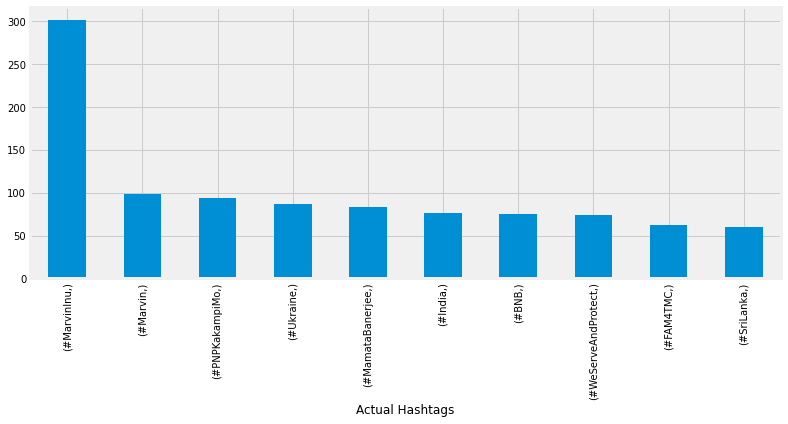

In [19]:
_=hashtags_list_df.value_counts()[:10].plot(kind='bar',figsize=(12,5),xlabel='Actual Hashtags')

In [20]:
#Convert hastags to lowercase
hashtags_list_df['hashtag'] = hashtags_list_df['hashtag'].str.lower()

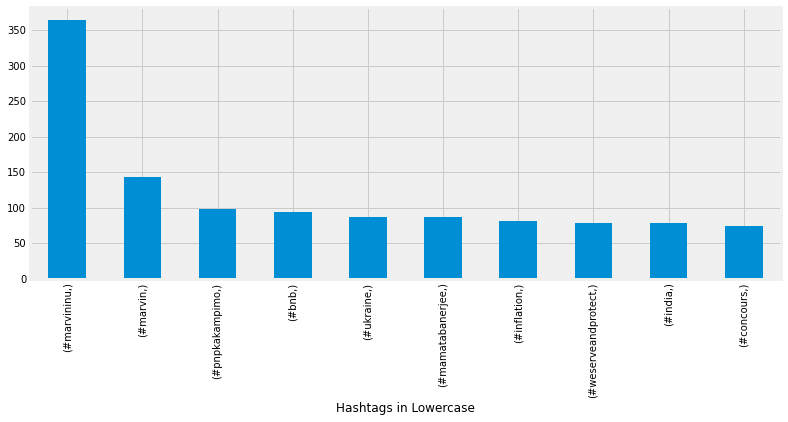

In [21]:
_=hashtags_list_df.value_counts()[:10].plot(kind='bar',figsize=(12,5),xlabel='Hashtags in Lowercase')

In [22]:
user_summary=df_tweet.groupby('original_author').agg({'cleaned_text':'count','followers_count':'max',
                                         'polarity':'mean','subjectivity':'mean', 'sentiment':pd.Series.mode})

In [23]:
user_summary.sort_values(by='cleaned_text',ascending=False)

,cleaned_text,followers_count,polarity,subjectivity,sentiment
original_author,,,,,
zaizaiUmar,50,761,0.112110,0.293913,Positive
jay21021985d,50,40,0.046095,0.207179,Neutral
Prospertom06,50,350,0.239399,0.387006,Positive
iamravimortha,50,424,-0.000917,0.016750,Neutral
Priyanka_Salve,50,479,0.060875,0.269809,Neutral
...,...,...,...,...,...
ArchibaldBlume,7,8,0.188961,0.453896,"[Neutral, Positive]"
RulerDeadly,6,0,0.083333,0.375000,"[Negative, Neutral, Positive]"
electriccalcul1,2,1,0.125000,0.250000,"[Neutral, Positive]"


Sentiment summary of the tweets

In [24]:
text_grouped = df_tweet.groupby('sentiment').count()['cleaned_text'].reset_index()

In [25]:
text_grouped

,sentiment,cleaned_text
0,Negative,2808
1,Neutral,14674
2,Positive,6467


<AxesSubplot:xlabel='sentiment', ylabel='count'>

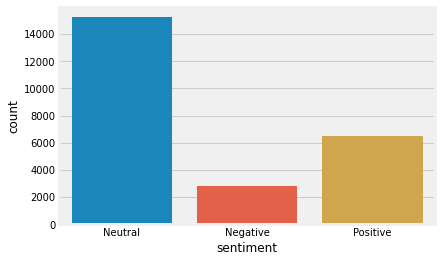

In [26]:
sns.countplot(x='sentiment', data=df_tweet)

**Most frequent words in our tweets dataset**

In [28]:
english_tweets=cleaner.remove_non_english_tweets(df_tweet)

In [29]:
# text Preprocessing
english_tweets['cleaned_text'] = english_tweets['cleaned_text'].str.lower()
english_tweets['cleaned_text'] = english_tweets['cleaned_text'].apply(
    lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))

In [35]:
all_words=' '.join(english_tweets.cleaned_text.values)
wordcloud_obj=WordCloud(width=1000,height=600,stopwords=STOPWORDS).generate(all_words)

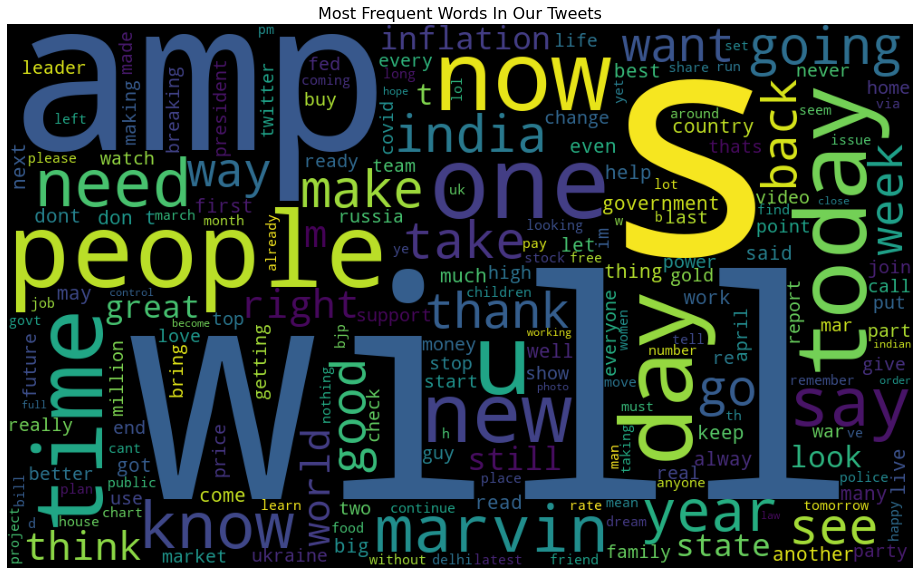

In [36]:
plt.figure(figsize=(20, 10))

plt.imshow(wordcloud_obj)
plt.axis('off')
plt.title('Most Frequent Words In Our Tweets',fontsize=16)
plt.show()

### Sentiment Analysis

In [38]:
len(all_words)

1357882

### Topic modeling

In [39]:
def preprocess_data(tweets_df):
    # Converting tweets to list of words For feature engineering
    sentence_list = [tweet for tweet in tweets_df['cleaned_text']]
    word_list = [sent.split() for sent in sentence_list]    
    new_word_list=[]
    for sent in word_list:
        new_word_list.append([word for word in sent if word not in STOPWORDS])
    
    # Create dictionary which contains Id and word 
    word_to_id = corpora.Dictionary(new_word_list)
    corpus_1 = [word_to_id.doc2bow(tweet) for tweet in new_word_list]

    return new_word_list, word_to_id, corpus_1

In [41]:
word_list, id2word, corpus=preprocess_data(english_tweets)

In [52]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)

In [53]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('will', 0.028676491),
   ('100', 0.012872445),
   ('day', 0.012720065),
   ('online', 0.011067009),
   ('full', 0.011063557),
   ('world', 0.010907545),
   ('know', 0.010736074),
   ('minister', 0.009187041),
   ('even', 0.00850663),
   ('good', 0.007906673)]),
 (1,
  [('…', 0.06567156),
   ('follow', 0.02109896),
   ('india', 0.019904401),
   ('back', 0.013428991),
   ('today', 0.011241351),
   ('please', 0.009994394),
   ('details', 0.009219025),
   ('man', 0.00900492),
   ('sec', 0.008097089),
   ('power', 0.0075763585)]),
 (2,
  [('one', 0.017847283),
   ('people', 0.013858622),
   ('now', 0.012516401),
   ('us', 0.010749755),
   ('cartoon', 0.006929816),
   ('time', 0.006880512),
   ('country', 0.0068507954),
   ('make', 0.0066552632),
   ('two', 0.006476327),
   ('need', 0.006450591)]),
 (3,
  [('amp', 0.035370924),
   ('new', 0.015696071),
   ('profile', 0.012136919),
   ('pm', 0.010136526),
   ('2022', 0.008340179),
   ('life', 0.006594611),
   ('april', 0.00651093),
 

### Model Analysis

In [54]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
doc_lda = lda_model[corpus]


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)


Perplexity:  -10.333145913904765

 Ldamodel Coherence Score/Accuracy on Tweets:  0.4995383763503202


In [55]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.189927  0.195279       1        1  25.610870
1     -0.246337  0.124206       2        1  23.526213
0      0.019367 -0.124461       3        1  18.491531
4      0.026619 -0.126506       4        1  18.281969
3      0.010425 -0.068519       5        1  14.089417, topic_info=         Term         Freq        Total Category  logprob  loglift
10          …  2271.000000  2271.000000  Default  30.0000  30.0000
739       amp   733.000000   733.000000  Default  29.0000  29.0000
108      will   780.000000   780.000000  Default  28.0000  28.0000
147    follow   730.000000   730.000000  Default  27.0000  27.0000
3811    india   689.000000   689.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1347     look    64.329124    65.085775   Topic5  -5.7743   1.9481
464    friday    61.505719    62.270946   Topic5  -5.8192   1.9474
3365  profile   251.347456   257.130224   Topic5  -4.4115   1.9370
952        ⁦⁩    70.891557    71.786085   Topic5  -5.6772   1.9472
292    upside    85.164371    86.714022   Topic5  -5.4938   1.9417

[188 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1694      5  0.996026      1
216       4  0.998409     10
1073      3  0.997646    100
2502      5  0.991946     15
1486      4  0.998063      2
...     ...       ...    ...
1434      3  0.989415     ’s
10        2  0.999701      …
952       5  0.989050     ⁦⁩
1873      3  0.993927      🚀
7043      4  0.996039  🟩🟩🟩🟩🟩

[178 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 5, 4])